In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")


In [2]:
messages = [
    {"role": "user", "content": """Who was the President of Mars in 1997?"""},
]


inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)


In [ ]:
num_generations = 3
for _ in range(num_generations):
    outputs = model.generate(**inputs, max_new_tokens=100, do_sample = True, temperature=0.7, top_p = 0.5, top_k=100)
    print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

In [ ]:
# load a small reward model (score single Q+A)
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
model_name = "OpenAssistant/reward-model-deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
rm = AutoModelForSequenceClassification.from_pretrained(model_name)  # ~738MB file

question = "Explain nuclear fusion like I'm five."
answer  = "Nuclear fusion is when atoms stick together and release lots of energy."

inputs = tokenizer(question, answer, return_tensors="pt", truncation=True)
logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
score = logits.item()
print("RM score:", score)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RM score: 2.114962100982666


In [26]:
questions = ["What is photosynthesis?", "What is photosynthesis?", "Who is the president of Mars?", "Who is the president of Mars?"]
answers  = [
    "Photosynthesis is the process by which animals, fishes, and some birds convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. ",
    "Photosynthesis is the process by which plants, algae, and some bacteria convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. ", 
    "The president of Mars is none other than Elon Musk, Tesla CEO", 
    "The President of mars is not a real thing, its a fictional reference from the StarWars movie"

]

inputs = tokenizer(questions, answers, return_tensors="pt", truncation=True, padding=True)
logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
print("RM score:", logits)

RM score: tensor([ 0.5651,  3.0007,  2.9940, -2.5534], grad_fn=<SqueezeBackward0>)


In [20]:
rm.named_modules

<bound method Module.named_modules of DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=

# For Correct Answers 

['Nuclear', 'fusion', 'is', 'when', 'atoms', 'are', 'fused', 'together', 'and', 'release', 'lots', 'of', 'energy.']


Processing:: 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


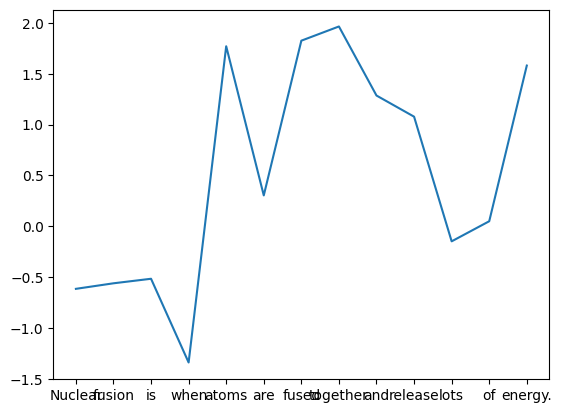

 Nuclear fusion is when atoms are fused together and release lots of energy.


In [23]:
import matplotlib.pyplot as plt
from tqdm import tqdm
question = "Explain nuclear fusion like I'm five."
answer  = "Nuclear fusion is when atoms are fused together and release lots of energy."
answers = answer.split(" ")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(answers, scores)
plt.show()
print(context)

['Photosynthesis', 'is', 'the', 'process', 'by', 'which', 'animals,', 'fishes,', 'and', 'some', 'birds', 'convert', 'light', 'energy', 'into', 'chemical', 'energy,', 'producing', 'sugars', '(food)', 'and', 'oxygen.', "It's", 'a', 'vital', 'biochemical', 'process', 'that', 'underpins', 'most', 'life', 'on', 'Earth', 'by', 'providing', 'a', 'source', 'of', 'energy', 'and', 'oxygen.', '']


Processing:: 100%|██████████| 42/42 [00:05<00:00,  7.02it/s]


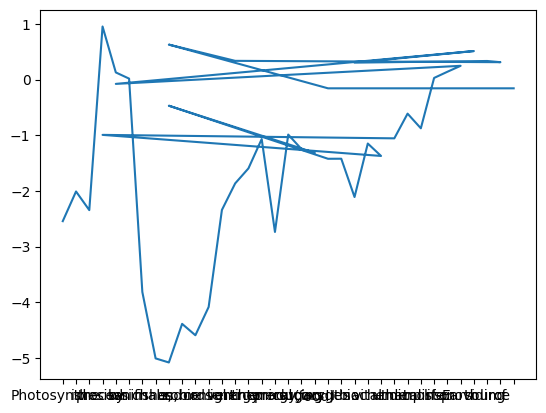

 Photosynthesis is the process by which animals, fishes, and some birds convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. 


In [ ]:
question = "what is Photosynthesis?"
answer  = "Photosynthesis is the process by which plants, algae, and some bacteria convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen."
answers = answer.split(" ")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(answers, scores)
plt.show()
print(context)

In [16]:
context

"Photosynthesisistheprocessbywhichanimals,fishes,andsomebirdsconvertlightenergyintochemicalenergy,producingsugars(food)andoxygen.It'savitalbiochemicalprocessthatunderpinsmostlifeonEarthbyprovidingasourceofenergyandoxygen."

# For Wrong Answers

In [13]:
question = "Explain nuclear fusion like I'm five."
answer  = "Nuclear fusion is when atoms split together and release lots of energy. An uncontrolled on with Markov K greater will result in explosion"
answers = answer.split(" ")

['Nuclear', 'fusion', 'is', 'when', 'atoms', 'split', 'together', 'and', 'release', 'lots', 'of', 'energy.', 'An', 'uncontrolled', 'on', 'with', 'Markov', 'K', 'greater', 'will', 'result', 'in', 'explosion']


Processing:: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s]


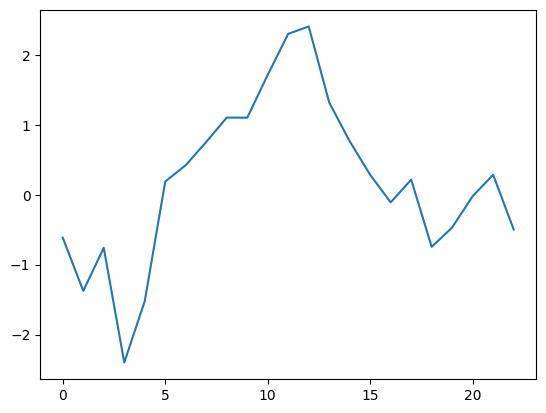

In [ ]:

print(answers)
context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(answers, scores)
plt.show()
print(context)

In [ ]:
question = "what is Photosynthesis?"
answer  = "Photosynthesis is the process by which animals, fishes, and some birds convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. "
answers = answer.split(" ")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(answers, scores)
plt.show()
print(context)